In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from synet.visualization import plot_entropy_with_events
from synet.networks.random import random_two_split_network
from synet.config import measures

In [2]:
np.random.seed(1872631)
n_inter_events=40
n_events = 5000
n_agents=100
dt = 3*n_agents + 1
n_sample=10
n_networks = 300
output_fp = Path("output", "event_detection.csv")

In [3]:
def detect_peak(entropy):
    entropy_max = np.max(entropy)
    return round(np.mean(np.where(entropy==entropy_max)[0]))

def benchmark_intervals(net, dt):
    cur_event = 0
    l_bounds = []
    u_bounds = []
    events = mix_events(net)
    bench_events = []
    for i_event in range(len(events)):
        if events[i_event] <= dt//2 or events[i_event] >= net.n_events-dt//2:
            continue
        if i_event == 0:
            lower_bound = 0
        else:
            lower_bound = (events[i_event] - events[i_event-1])//2 + events[i_event-1]
        lower_bound = max(dt//2, lower_bound)
        if i_event == len(events)-1:
            upper_bound = net.n_events
        else:
            upper_bound = (events[i_event+1]- events[i_event])//2 + events[i_event]
        upper_bound = min(net.n_events - dt//2, upper_bound)
        l_bounds.append(lower_bound)
        u_bounds.append(upper_bound)
        bench_events.append(events[i_event])
    return np.array((l_bounds, u_bounds)).T, np.array(bench_events)

def detect_all_peaks(entropy, intervals):
    peaks = []
    for lower_bound, upper_bound in intervals:
        peaks.append(lower_bound + detect_peak(entropy[lower_bound:upper_bound]))
    return peaks

def mix_events(net):
    events = np.where(net.event_sources==2)[0]
    cur_mix_events = []
    for ev in events:
        agents = net.participants[ev]
        if np.all(agents<n_agents//2) or np.all(agents>=n_agents//2):
            continue
        cur_mix_events.append(ev)
    return np.array(cur_mix_events, dtype=int)

def average_event_error(measure, networks, dt):
    entropy_t = measure.entropy_t(networks, dt, n_jobs=32)
    avg_error = []
    for i_net, net in enumerate(networks):
        entropy = entropy_t[i_net]
        intervals, events = benchmark_intervals(net, dt)
        peaks = detect_all_peaks(entropy, intervals)
        if len(peaks) > 0:
            avg_error.append(np.mean(np.abs(peaks-events)))
        else:
            avg_error.append(np.nan)
    return np.mean(avg_error), stats.sem(avg_error, nan_policy="omit")

def average_random_error(intervals, events):
    avg_error = []
    for i_event in range(len(intervals)):
        errors = np.arange(intervals[i_event][0] - events[i_event], intervals[i_event][1] - events[i_event])
        avg_error.append(np.mean(np.abs(errors)))
    return np.mean(avg_error)

def get_random_error(networks, dt):
    all_err = []
    for net in networks:
        intervals, events = benchmark_intervals(net, dt)
        all_err.append(average_random_error(intervals, events))
    return np.mean(all_err)


In [4]:
def create_dataframe(networks):
    all_dt = np.arange(n_agents//4, n_agents*3, n_agents//10)
    all_dt[all_dt %2 == 0] += 1
    df = pd.DataFrame()
    df["dt"] = all_dt
    for measure_name, measure_class in measures.items():
        err = []
        sem = []
        xvals = []
        measure = measure_class()
        for i_dt, dt in enumerate(all_dt):
            if (dt % 2) == 0:
                dt += 1
            xvals.append(dt)
            avg_error, avg_sem = average_event_error(measure, networks, dt)
            err.append(avg_error)
            sem.append(avg_sem)
        df[measure_name] = err
        df[measure_name+"_err"] = sem

    df["random"] = [get_random_error(networks, dt) for dt in all_dt]
    return df

In [5]:
def plot_data(df, measure_names):
    random = df["random"].values
    dt = df["dt"].values
    for name in measure_names:
        err = df[name].values
        sem = df[name+"_err"].values
        plt.errorbar(dt, 1-err/random, sem/random, label=name)
    plt.legend()
    plt.show()

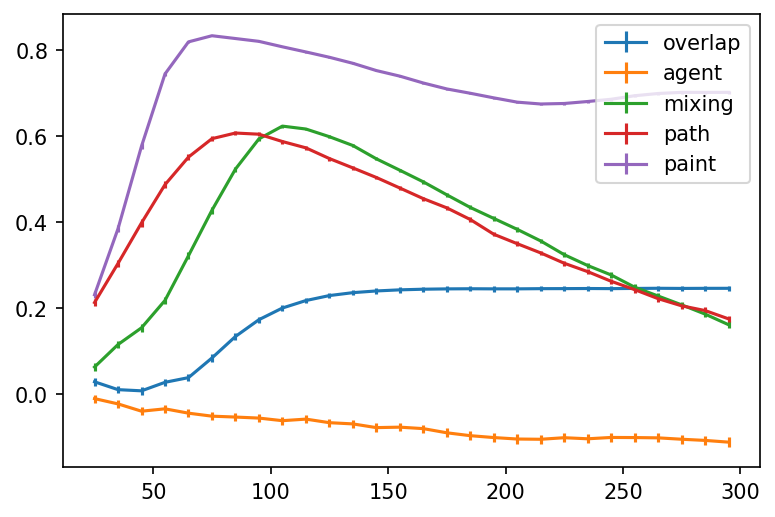

In [6]:
try:
    df = pd.read_csv(output_fp)
except FileNotFoundError:
    networks = [random_two_split_network(n_events, n_inter_events, n_agents) for _ in range(n_networks)]
    df = create_dataframe(networks)
    df.to_csv(output_fp, index=False)

plt.figure(dpi=150)
plot_data(df, list(measures))

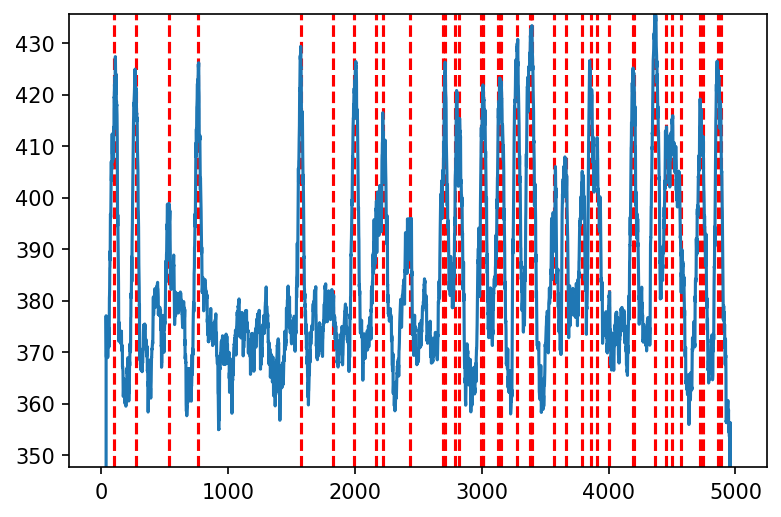

In [7]:
plt.figure(dpi=150)
network = random_two_split_network(n_events, n_inter_events, n_agents)
entropy_t = measures["paint"]().entropy_t(network, dt=80)
plot_entropy_with_events(entropy_t, events=np.where(network.event_sources==2)[0])